In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v2 import keras
from tensorflow.compat.v2.keras import layers
import tensorflow_datasets as tfds

In [0]:
%tensorflow_version 2.x
print(tf.__version__)
!nvidia-smi

2.2.0-rc2
Mon Apr 13 16:09:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory 

## Eager execution

TensorFlow Datasets is compatible with both TensorFlow [Eager mode](https://www.tensorflow.org/guide/eager) and Graph mode. For this colab, we'll run in Eager mode.

In [0]:
 tf.enable_v2_behavior()
 tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'gr

In [0]:
train_data, info = tfds.load(name="cifar10", split='train[1000:]',  with_info = True, data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')
valid_data = tfds.load(name="cifar10", split='train[:1000]', data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')
test_data = tfds.load(name="cifar10", split=tfds.Split.TEST, data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')
info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.0,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [0]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [0]:
# 建立一個dict用來計數每個類別標籤數量
train_dict = {}
# 讀取整個訓練資料集
for data in train_data:
    # 將讀取到的label轉乘numpy格式
    label = data['label'].numpy()
    # 以label沒dict的key，取出dict中的值+1，如果key在dict中沒有值預設為0
    train_dict[label] = train_dict.setdefault(label, 0) + 1
    # train_dict.setdefault(label, 0) + 1
print(train_dict)

{5: 4898, 1: 4918, 2: 4906, 0: 4878, 8: 4890, 9: 4899, 6: 4917, 3: 4898, 7: 4888, 4: 4908}


In [0]:
train_num = 40000  # 訓練資料數量
train_data = train_data.shuffle(train_num)  # 打散資料集

Label: 8


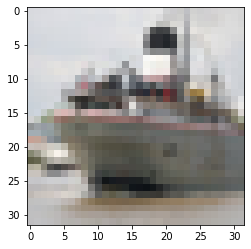

In [0]:
for example in train_data.take(1):  # Only take a single example
  image, label = example["image"], example["label"]
  plt.figure()
  plt.imshow(image.numpy())
  print("Label: %d" % label.numpy())

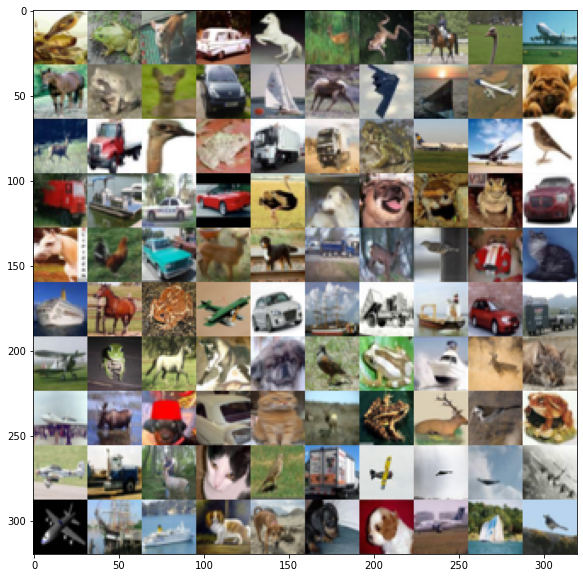

In [0]:
# 建立一個顯示影像的陣列
output = np.zeros((32 * 10, 32 * 10, 3), dtype=np.uint8)
row = 0
for data in train_data.batch(10).take(10):
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
# 設定顯示視窗大小
plt.figure(figsize=(10, 10))
# 顯示影像
plt.imshow(output)

資料愈處理(Data Prepossessing ):
- 影像資料：將輸入資料做標準化，全部除以255，將像素值縮放到0~1之間。
- 標籤資料：做One-hot Encoding，例如類別2為[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]。

In [0]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [0]:
train_data

<DatasetV1Adapter shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
# 載入前面的資料預處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-1（全連接神經網路）
建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄30%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [0]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x) 
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0   

In [0]:
model_dir = '/content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models'  # 設定儲存權重目錄
if os.path.exists(model_dir) == False:
    os.makedirs(model_dir)  # 創建儲存權重目錄

In [0]:
# 將訓練記錄，存成TensorBoard的紀錄檔
log_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.hd5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [0]:
model_1.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [0]:
history_1 = model_1.fit(train_data,
                        epochs=10, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/10
753/766 [============================>.] - ETA: 0s - loss: 1.9846 - categorical_accuracy: 0.2634WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


766/766 [==============================] - 8s 10ms/step - loss: 1.9826 - categorical_accuracy: 0.2641 - val_loss: 1.8725 - val_categorical_accuracy: 0.3380
Epoch 2/10
764/766 [============================>.] - ETA: 0s - loss: 1.8203 - categorical_accuracy: 0.3419INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


766/766 [==============================] - 7s 9ms/step - loss: 1.8209 - categorical_accuracy: 0.3418 - val_loss: 1.8254 - val_categorical_accuracy: 0.3510
Epoch 3/10
766/766 [==============================] - 6s 8ms/step - loss: 1.7574 - categorical_accuracy: 0.3699 - val_loss: 1.7871 - val_categorical_accuracy: 0.3490
Epoch 4/10
765/766 [============================>.] - ETA: 0s - loss: 1.7091 - categorical_accuracy: 0.3883INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


766/766 [==============================] - 7s 10ms/step - loss: 1.7092 - categorical_accuracy: 0.3883 - val_loss: 1.7079 - val_categorical_accuracy: 0.4090
Epoch 5/10
766/766 [==============================] - 6s 8ms/step - loss: 1.6745 - categorical_accuracy: 0.4011 - val_loss: 1.7053 - val_categorical_accuracy: 0.4040
Epoch 6/10
752/766 [============================>.] - ETA: 0s - loss: 1.6463 - categorical_accuracy: 0.4119INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


766/766 [==============================] - 7s 10ms/step - loss: 1.6453 - categorical_accuracy: 0.4123 - val_loss: 1.6856 - val_categorical_accuracy: 0.4220
Epoch 7/10
766/766 [==============================] - 6s 8ms/step - loss: 1.6293 - categorical_accuracy: 0.4198 - val_loss: 1.6987 - val_categorical_accuracy: 0.4010
Epoch 8/10
762/766 [============================>.] - ETA: 0s - loss: 1.6021 - categorical_accuracy: 0.4281INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models/Best-model-1.hd5/assets


766/766 [==============================] - 7s 10ms/step - loss: 1.6017 - categorical_accuracy: 0.4281 - val_loss: 1.6263 - val_categorical_accuracy: 0.4390
Epoch 9/10
766/766 [==============================] - 6s 8ms/step - loss: 1.5951 - categorical_accuracy: 0.4299 - val_loss: 1.6651 - val_categorical_accuracy: 0.3990
Epoch 10/10
766/766 [==============================] - 6s 8ms/step - loss: 1.5838 - categorical_accuracy: 0.4341 - val_loss: 1.6784 - val_categorical_accuracy: 0.4090


In [0]:
history_1.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

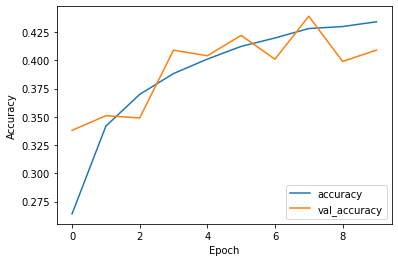

In [0]:
plt.plot(history_1.history['categorical_accuracy'], label='accuracy')
plt.plot(history_1.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [0]:
loss, acc = model_1.evaluate(test_data)
print('\nModel-1 Accuracy: {}%'.format(acc))

157/157 [==============================] - 2s 15ms/step - loss: 1.5880 - categorical_accuracy: 0.4344

Model-1 Accuracy: 0.4343999922275543%
